# Statistical Analysis

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from pipeline import *


## Load Data

In [3]:
df_teams = pd.read_csv("dataset/cleaned/teams.csv")
df_teams_post = pd.read_csv("dataset/cleaned/teams_post.csv")

df_series_post = pd.read_csv("dataset/cleaned/series_post.csv")
df_coaches = pd.read_csv("dataset/cleaned/coaches.csv")
df_awards_players = pd.read_csv("dataset/cleaned/awards_players.csv")

aux_1 = pd.read_csv("dataset/cleaned/players.csv")
aux_2 = pd.read_csv("dataset/cleaned/players_teams.csv")

df_players = merge_player_info(aux_1, aux_2)


## Functions

In [4]:
def show_corr_matrix(df, threshold=0.7):
    # Select only the numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    correlation_matrix = numeric_df.corr()

    # Mask the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    plt.figure(figsize=(30, 16))
    sns.heatmap(correlation_matrix, annot=True,
                cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title("Correlation Matrix")
    plt.show()

    # Calculate the number of correlation values greater than the threshold in the lower triangle
    lower_triangle = correlation_matrix.where(
        np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

    num_corr_greater_than_08 = (lower_triangle > threshold).sum().sum()
    print(f"Number of correlation values greater than {threshold}:",
          num_corr_greater_than_08)

    num_corr_lower_than_08 = (lower_triangle < -threshold).sum().sum()
    print(f"Number of correlation values lower than -{threshold}:",
          num_corr_lower_than_08)


In [5]:
def show_box_plots(df, outlier_threshold=30):
    # Select only the numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    num_cols = len(numeric_df.columns)
    num_cols_per_row = 4  # Adjust as needed
    num_rows = math.ceil(num_cols / num_cols_per_row)
    fig, axs = plt.subplots(
        nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 5*num_rows))
    axs = axs.flatten()

    for i, col in enumerate(numeric_df.columns):
        q1 = numeric_df[col].quantile(0.25)
        q3 = numeric_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = len(
            numeric_df[(numeric_df[col] < lower_bound) | (numeric_df[col] > upper_bound)])

        axs[i].boxplot(numeric_df[col])
        axs[i].set_ylim(numeric_df[col].min() - 0.1 * numeric_df[col].max(),
                        numeric_df[col].max() + 0.1 * numeric_df[col].max())

        axs[i].set_xlabel(f"mean: {numeric_df[col].mean():.2f}")

        if num_outliers > outlier_threshold:
            axs[i].set_title(f"{col} ({num_outliers} outliers)", color='red')
        else:
            axs[i].set_title(f"{col} ({num_outliers} outliers)")

    # Hide empty subplots
    for i in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()


In [6]:
def show_hist_plots(df):
    # Select only the numeric columns
    df = df.select_dtypes(include=['number'])

    num_cols = len(df.columns)
    num_cols_per_row = 4  # Adjust as needed
    num_rows = math.ceil(num_cols / num_cols_per_row)
    fig, axs = plt.subplots(
        nrows=num_rows, ncols=num_cols_per_row, figsize=(20, 5*num_rows))
    axs = axs.flatten()

    for i, col in enumerate(df.columns):
        # Calculate sttistics
        col_data = df[col]
        mean = col_data.mean()
        q1 = col_data.quantile(0.25)
        q3 = col_data.quantile(0.75)

        axs[i].hist(col_data, bins=20, edgecolor='black', color='lightblue')

        # x label as the column name

        axs[i].set_xlabel(col)
        
        # Add vertical lines for statistics
        axs[i].axvline(mean, color='red', linestyle='solid',
                       linewidth=2.5, label='Mean')
        axs[i].axvline(q1, color='red', linestyle='dashed',
                       linewidth=2.5, label='Q1')
        axs[i].axvline(q3, color='red', linestyle='dashed',
                       linewidth=2.5, label='Q3')

    # Hide empty subplots
    for i in range(num_cols, num_rows * num_cols_per_row):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()


In [7]:
def show_clustering(data, x_column, y_column, n_clusters=10):
    # Select the specified columns for X
    X = data[[x_column, y_column]].values

    # Get the attribute names before scaling
    attribute_names = [x_column, y_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    cluster_labels = kmeans.labels_

    # Visualize the clusters in the reduced-dimensional space
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_

    plt.title("Clustering Players in PCA Space")
    plt.xlabel(attribute_names[0])
    plt.ylabel(attribute_names[1])

    plt.show()


## Data Exploration

### Loading Original Data

In [8]:
df_teams_og = pd.read_csv("dataset/original/teams.csv")
df_teams_post_og = pd.read_csv("dataset/original/teams_post.csv")

df_series_post_og = pd.read_csv("dataset/original/series_post.csv")
df_coaches_og = pd.read_csv("dataset/original/coaches.csv")
df_awards_players_og = pd.read_csv("dataset/original/awards_players.csv")

aux_1 = pd.read_csv("dataset/original/players.csv")
aux_2 = pd.read_csv("dataset/original/players_teams.csv")

df_players_og = merge_player_info(aux_1, aux_2)

In [9]:
df_list = [df_teams_og, df_teams_post_og, df_series_post_og,
           df_coaches_og, df_awards_players_og, df_players_og]

df_list_cleaned = [df_teams, df_teams_post, df_series_post,
                   df_coaches, df_awards_players, df_players]

df_names = ["Teams", "Teams Post", "Series Post",
            "Coaches", "Awards Players", "Players"]

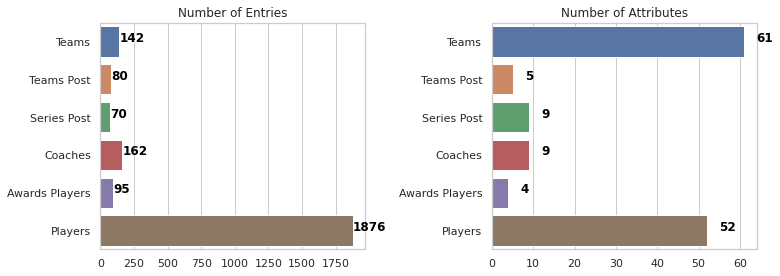

In [52]:
# Number of rows and columns for each dataframe
num_rows = [df.shape[0] for df in df_list]
num_columns = [df.shape[1] for df in df_list]

# Set a larger figure size
plt.figure(figsize=(11, 4))

# Create a bar plot for the number of rows
plt.subplot(1, 2, 1)
sns.barplot(x=num_rows, y=df_names, orient='h')
plt.title("Number of Entries")

# Add labels to the bars with adjusted positions
for i, v in enumerate(num_rows):
    plt.text(v + 3, i, str(v), color='black', fontweight='bold')

# Create a bar plot for the number of columns
plt.subplot(1, 2, 2)
sns.barplot(x=num_columns, y=df_names, orient='h')
plt.title("Number of Attributes")

# Add labels to the bars with adjusted positions
for i, v in enumerate(num_columns):
    plt.text(v+3 , i, str(v), color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [55]:
# Checking for missing values
print("Missing values in all dfs:")
missing_values_counts = []
for i, df in enumerate(df_list):
    missing_values_counts.append(df.isna().sum().sum())
    print(f"{df_names[i]}: {missing_values_counts[i]}")

# Which columns have missing values
print("\nColumns with missing values in all dfs:")
columns_with_missing = []
for i, df in enumerate(df_list):
    columns_with_missing.append(df.columns[df.isna().any()].tolist())
    print(f"{df_names[i]}: {columns_with_missing[i]}")

# Check for duplicates
print("\nDuplicates in all dfs:")
duplicates_counts = []
for i, df in enumerate(df_list):
    duplicates_counts.append(df.duplicated().sum())
    print(f"{df_names[i]}: {duplicates_counts[i]}")

# Check for columns with constant values
print("\nColumns with constant values in all dfs:")
constant_columns = []
for i, df in enumerate(df_list):
    constant_columns.append(df.columns[df.nunique() == 1].tolist())
    print(f"{df_names[i]}: {constant_columns[i]}")


Missing values in all dfs:
Teams: 430
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 2062

Columns with missing values in all dfs:
Teams: ['divID', 'firstRound', 'semis', 'finals']
Teams Post: []
Series Post: []
Coaches: []
Awards Players: []
Players: ['college', 'collegeOther']

Duplicates in all dfs:
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Columns with constant values in all dfs:
Teams: ['lgID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']
Teams Post: ['lgID']
Series Post: ['lgIDWinner', 'lgIDLoser']
Coaches: ['lgID']
Awards Players: ['lgID']
Players: ['lgID', 'firstseason', 'lastseason']


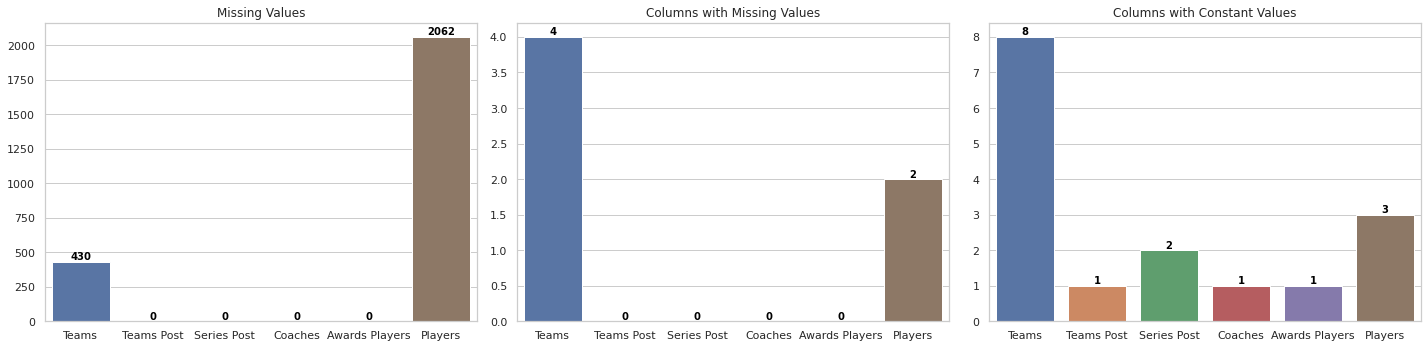

In [58]:
# Create visualizations
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
missing_values_plot = sns.barplot(x=df_names, y=missing_values_counts)
plt.title("Missing Values")

plt.subplot(1, 3, 2)
columns_with_missing_plot = sns.barplot(x=df_names, y=[len(cols) for cols in columns_with_missing])
plt.title("Columns with Missing Values")

plt.subplot(1, 3, 3)
constant_columns_plot = sns.barplot(x=df_names, y=[len(cols) for cols in constant_columns])
plt.title("Columns with Constant Values")

# Add labels to the bars
for bar in missing_values_plot.patches:
    missing_values_plot.annotate(format(bar.get_height(), '.0f'), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='center',
                                size=10, color='black', xytext=(0, 5),
                                textcoords='offset points', fontweight='bold')

for bar in columns_with_missing_plot.patches:
    columns_with_missing_plot.annotate(format(bar.get_height(), '.0f'), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='center',
                                size=10, color='black', xytext=(0, 5),
                                textcoords='offset points', fontweight='bold')

for bar in constant_columns_plot.patches:
    constant_columns_plot.annotate(format(bar.get_height(), '.0f'), 
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                ha='center', va='center',
                                size=10, color='black', xytext=(0, 5),
                                textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

## Data Cleaning Analysis

### Comparing Original Data to Cleaned Data

In [ ]:
# Checking for missing values after cleaning

print("\nMissing values in all dfs (cleaned):")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.isna().sum().sum()}")

# Check for duplicates after cleaning

print("\nDuplicates in all dfs:")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.duplicated().sum()}")

# Check for columns with constant values after cleaning

print("\nColumns with constant values in all dfs:")
for i, df in enumerate(df_list_cleaned):
    print(f"{df_names[i]}: {df.columns[df.nunique() == 1].tolist()}")



Missing values in all dfs (cleaned):
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Duplicates in all dfs:
Teams: 0
Teams Post: 0
Series Post: 0
Coaches: 0
Awards Players: 0
Players: 0

Columns with constant values in all dfs:
Teams: []
Teams Post: []
Series Post: []
Coaches: []
Awards Players: []
Players: []


As we can see, our cleaned data is now clean of any null or irrelevant constant attributes.

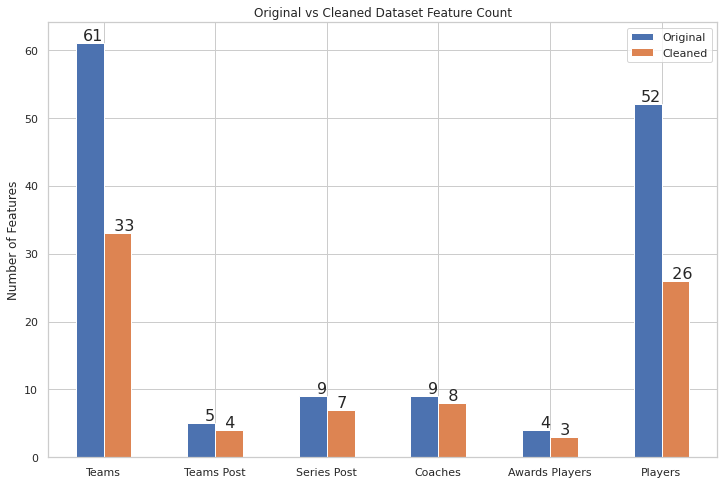

In [59]:
# Comparing the original and cleaned datasets sizes in terms of columns and rows on a graph

# Get the number of columns in each dataframe
df_sizes = [len(df.columns) for df in df_list]
df_sizes_cleaned = [len(df.columns) for df in df_list_cleaned]

# Create a DataFrame for the original and cleaned dataset sizes
df_sizes = pd.DataFrame(
    {"Original": df_sizes, "Cleaned": df_sizes_cleaned}, index=df_names)

# Create the bar plot
ax = df_sizes.plot.bar(rot=0, figsize=(12, 8))

# Add labels with numbers on top of the rectangles
for i, v in enumerate(df_sizes.index):
    ax.text(i, df_sizes.loc[v, "Original"], str(
        df_sizes.loc[v, "Original"]), ha='right', va='bottom', fontsize=16)
    ax.text(i, df_sizes.loc[v, "Cleaned"], "  "+str(
        df_sizes.loc[v, "Cleaned"]), ha='left', va='bottom', fontsize=16)

# Set the title
plt.title("Original vs Cleaned Dataset Feature Count")
plt.ylabel("Number of Features")
plt.show()


Removed the following columns from the original data:

In [ ]:
columns_not_in_cleaned = []

for og_df, cleaned_df in zip(df_list, df_list_cleaned):
    og_columns = set(og_df.columns)
    cleaned_columns = set(cleaned_df.columns)
    columns_diff = og_columns - cleaned_columns
    columns_not_in_cleaned.append(columns_diff)

for i, df_name in enumerate(df_names):
    print(
        f"Columns not in cleaned {df_name} dataframe: {list(columns_not_in_cleaned[i])}")


Columns not in cleaned Teams dataframe: ['awayL', 'opptmORB', 'd_3pa', 'seeded', 'awayW', 'tmORB', 'o_fta', 'arena', 'GP', 'o_fgm', 'd_stl', 'homeL', 'opptmTRB', 'o_asts', 'lgID', 'rank', 'tmTRB', 'o_3pa', 'o_fga', 'o_reb', 'semis', 'confW', 'd_3pm', 'firstRound', 'd_fta', 'opptmDRB', 'o_to', 'tmDRB', 'franchID', 'o_ftm', 'name', 'o_3pm', 'd_ftm', 'd_reb', 'homeW', 'd_fgm', 'divID', 'won', 'lost', 'finals', 'confL', 'd_fga']
Columns not in cleaned Teams Post dataframe: ['lgID']
Columns not in cleaned Series Post dataframe: ['lgIDWinner', 'lgIDLoser']
Columns not in cleaned Coaches dataframe: ['lgID']
Columns not in cleaned Awards Players dataframe: ['lgID']
Columns not in cleaned Players dataframe: ['GS', 'turnovers', 'fgAttempted', 'blocks', 'PostPoints', 'PostftAttempted', 'PostBlocks', 'lastseason', 'PostTurnovers', 'GP', 'rebounds', 'steals', 'PostfgAttempted', 'PostdRebounds', 'PostSteals', 'ftAttempted', 'lgID', 'PostDQ', 'oRebounds', 'assists', 'PostGP', 'dq', 'PostRebounds', 'P

## Data Preprocessing Analysis

TODO: Talk about feature selection and engineering

## Analysis

### Descriptive Statistics

#### Correlation Matrix


Correlation matrix for Teams


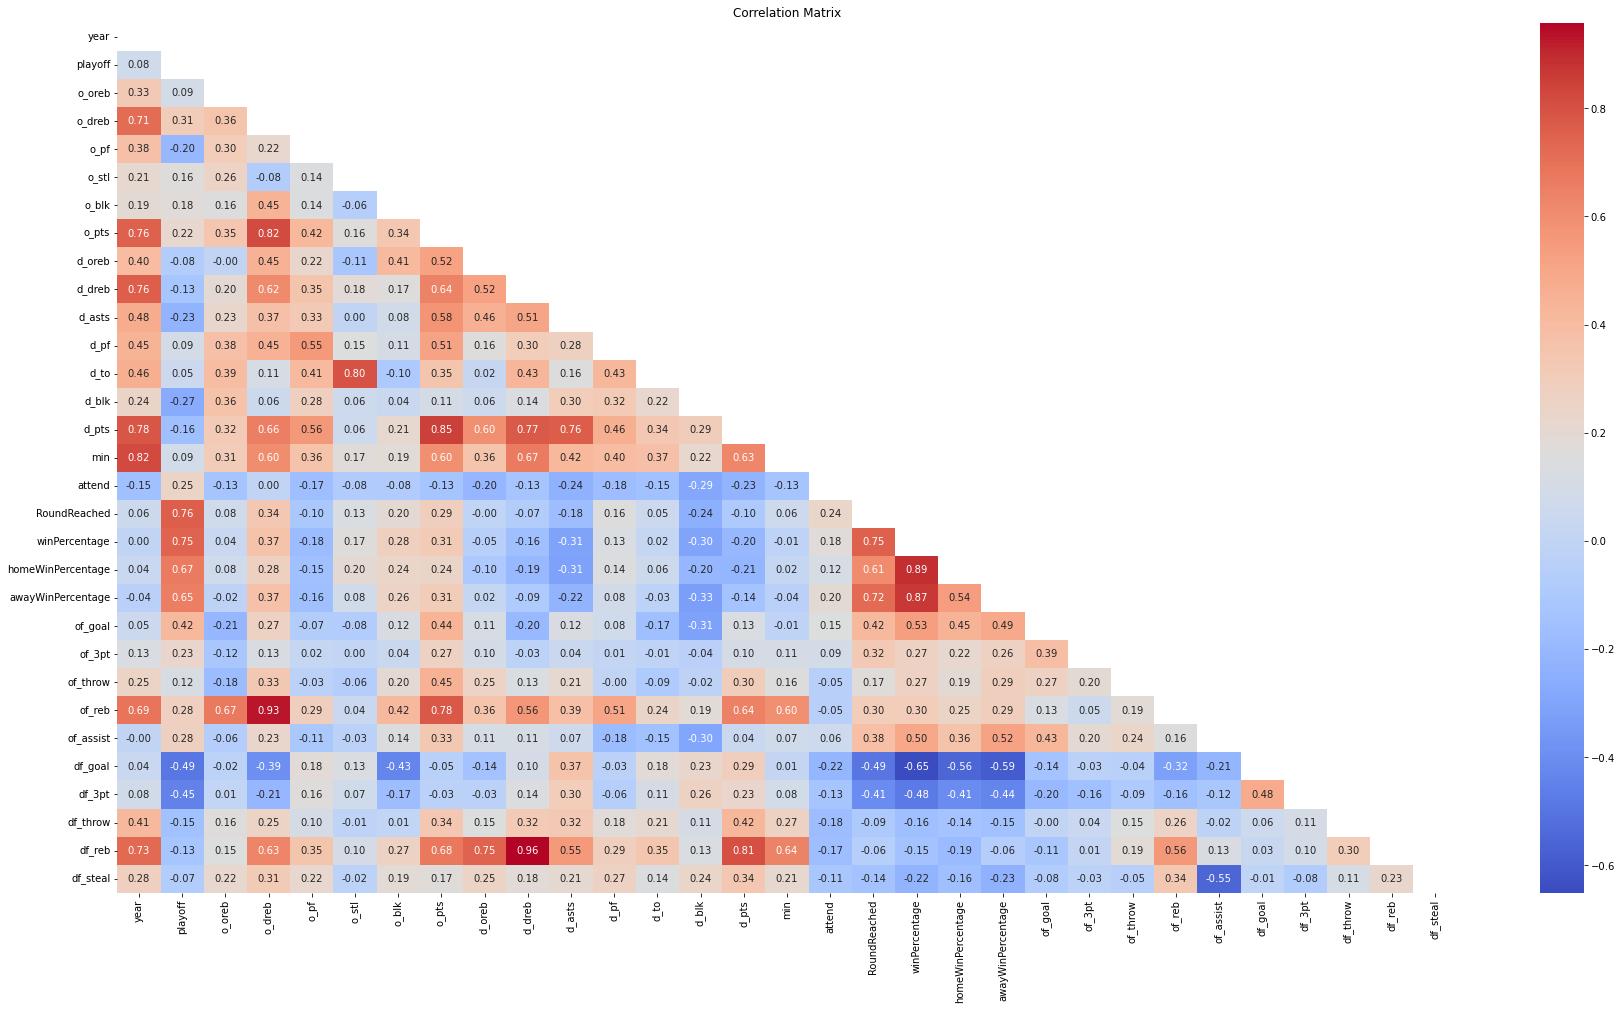

Number of correlation values greater than 0.7: 22
Number of correlation values lower than -0.7: 0

Correlation matrix for Coaches


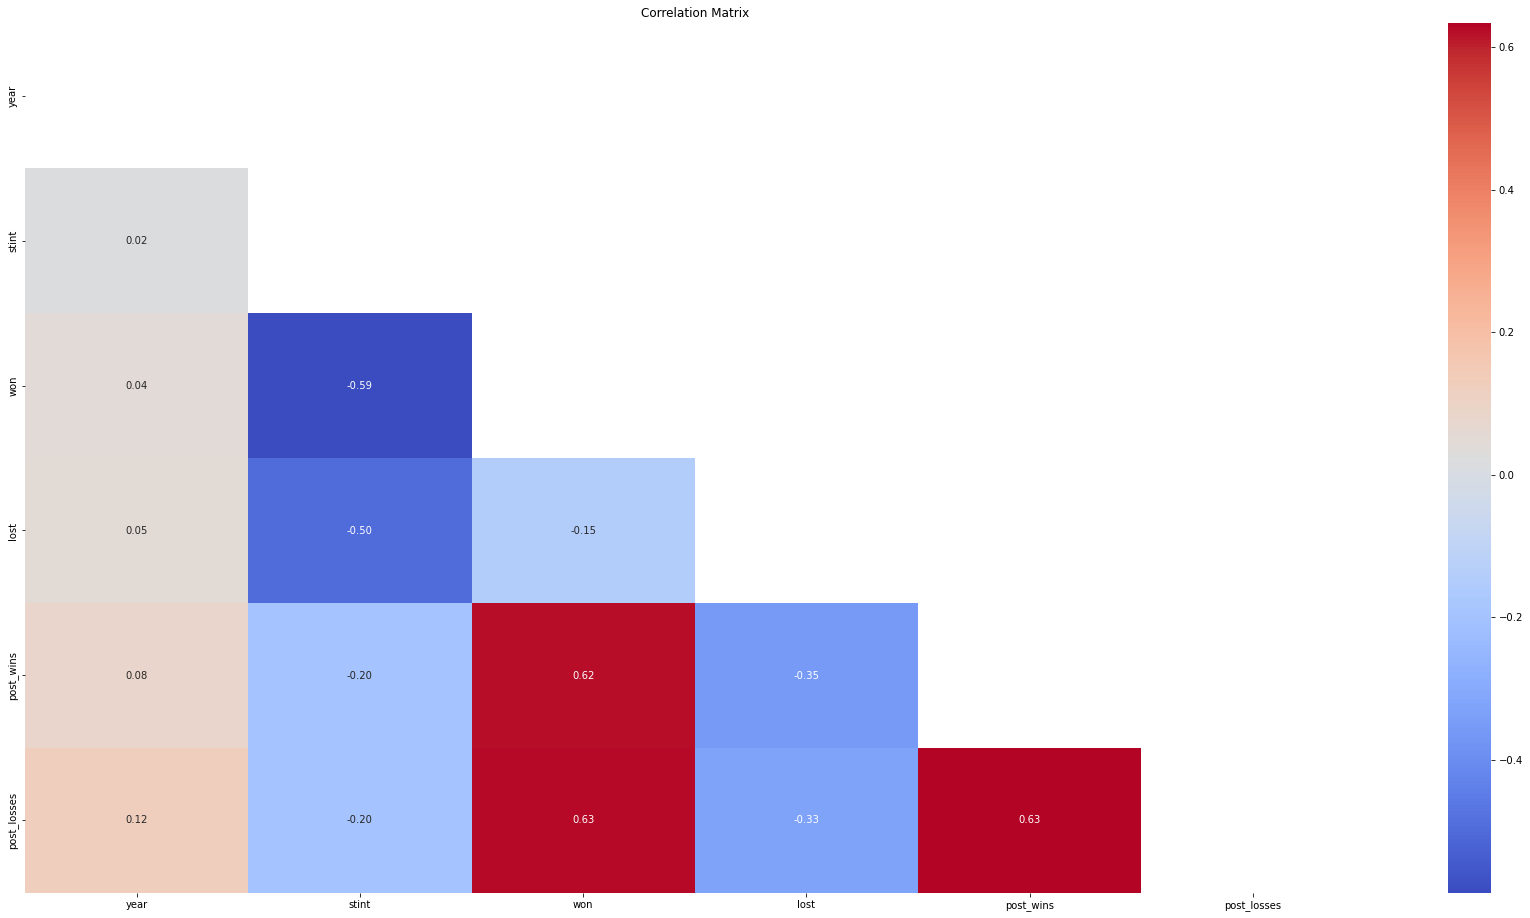

Number of correlation values greater than 0.7: 0
Number of correlation values lower than -0.7: 0

Correlation matrix for Players


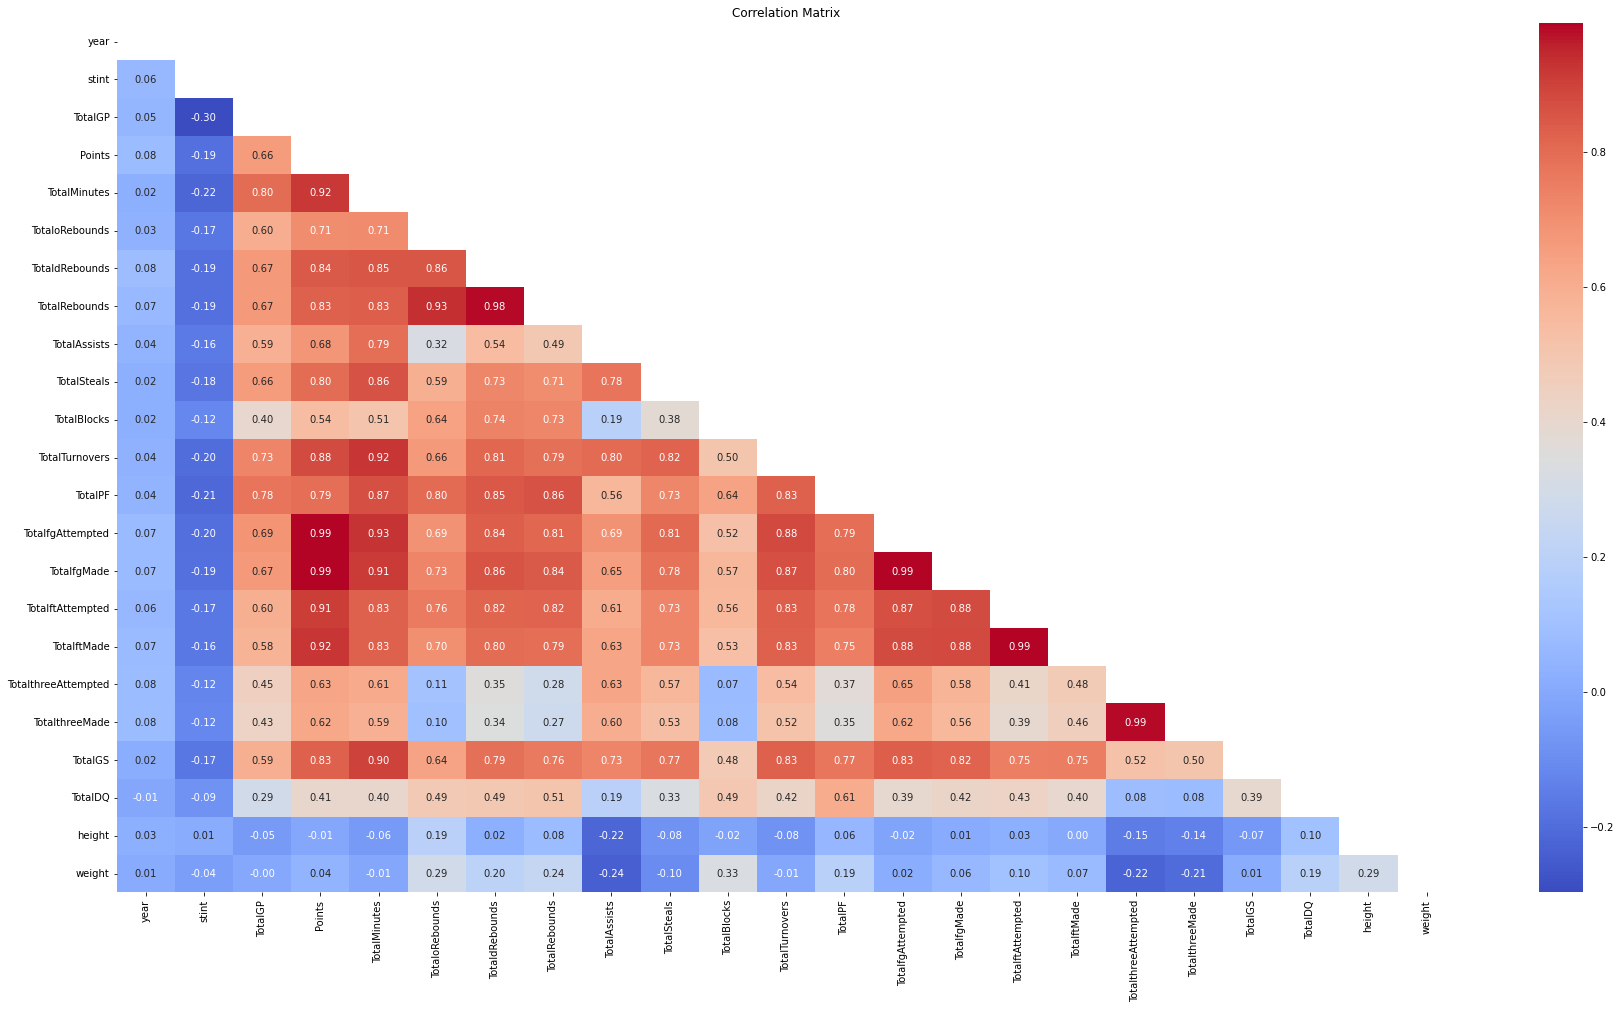

Number of correlation values greater than 0.7: 84
Number of correlation values lower than -0.7: 0


In [ ]:
# Looking for correlations between attributes in each df

for i, df in enumerate(df_list_cleaned):
    num = df.select_dtypes(include=['number'])
    if len(num.columns) > 3:
        print(f"\nCorrelation matrix for {df_names[i]}")
        show_corr_matrix(df)


Looking at the correlation matrix, we can see that there are a few attributes that are highly correlated with each other. Many of them are related to "winning conditions", as good players and teams will win more and these wins are conditioned by good performance in many metrics, for example. 

This is important to note because it means that we can potentially remove some of these attributes without losing too much information and thus, greatly reduce the high dimensionality of our data.

Looking at the df_teams dataframe and using the df_players to get player combined stats, in a abridged form, we can see the teams stats over the 10 years of data we have.

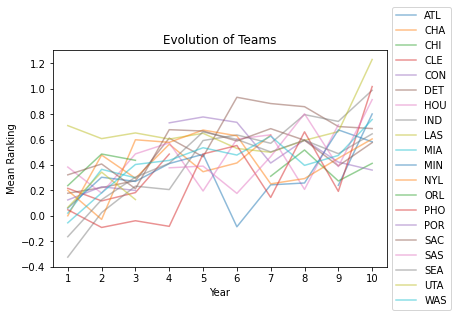

In [ ]:
df_pred = player_rankings(df_players)
df_players_teams = player_in_team_by_year(df_players)
df_players_teams = team_mean(df_players_teams, df_pred)

df_teams_evolution = df_players_teams.groupby(['tmID', 'year']).agg({
    'mean': 'mean'
}).reset_index()


df_teams_evolution = df_teams_evolution.pivot(
    index='year', columns='tmID', values='mean')

df_teams_evolution.plot(kind='line', stacked=False, alpha=0.5)

# Set the title and axis labels
plt.title('Evolution of Teams')
plt.xlabel('Year')
plt.ylabel('Mean Ranking')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(df_teams_evolution.index)
plt.show()


Important to note that there are teams that have changed names, confederation or just ended (lines that don't span over the 10 years) over the years, so we will need to account for that.

### Outliers

The easiest way to find outliers is to use boxplots in the data.


Box plots for Teams


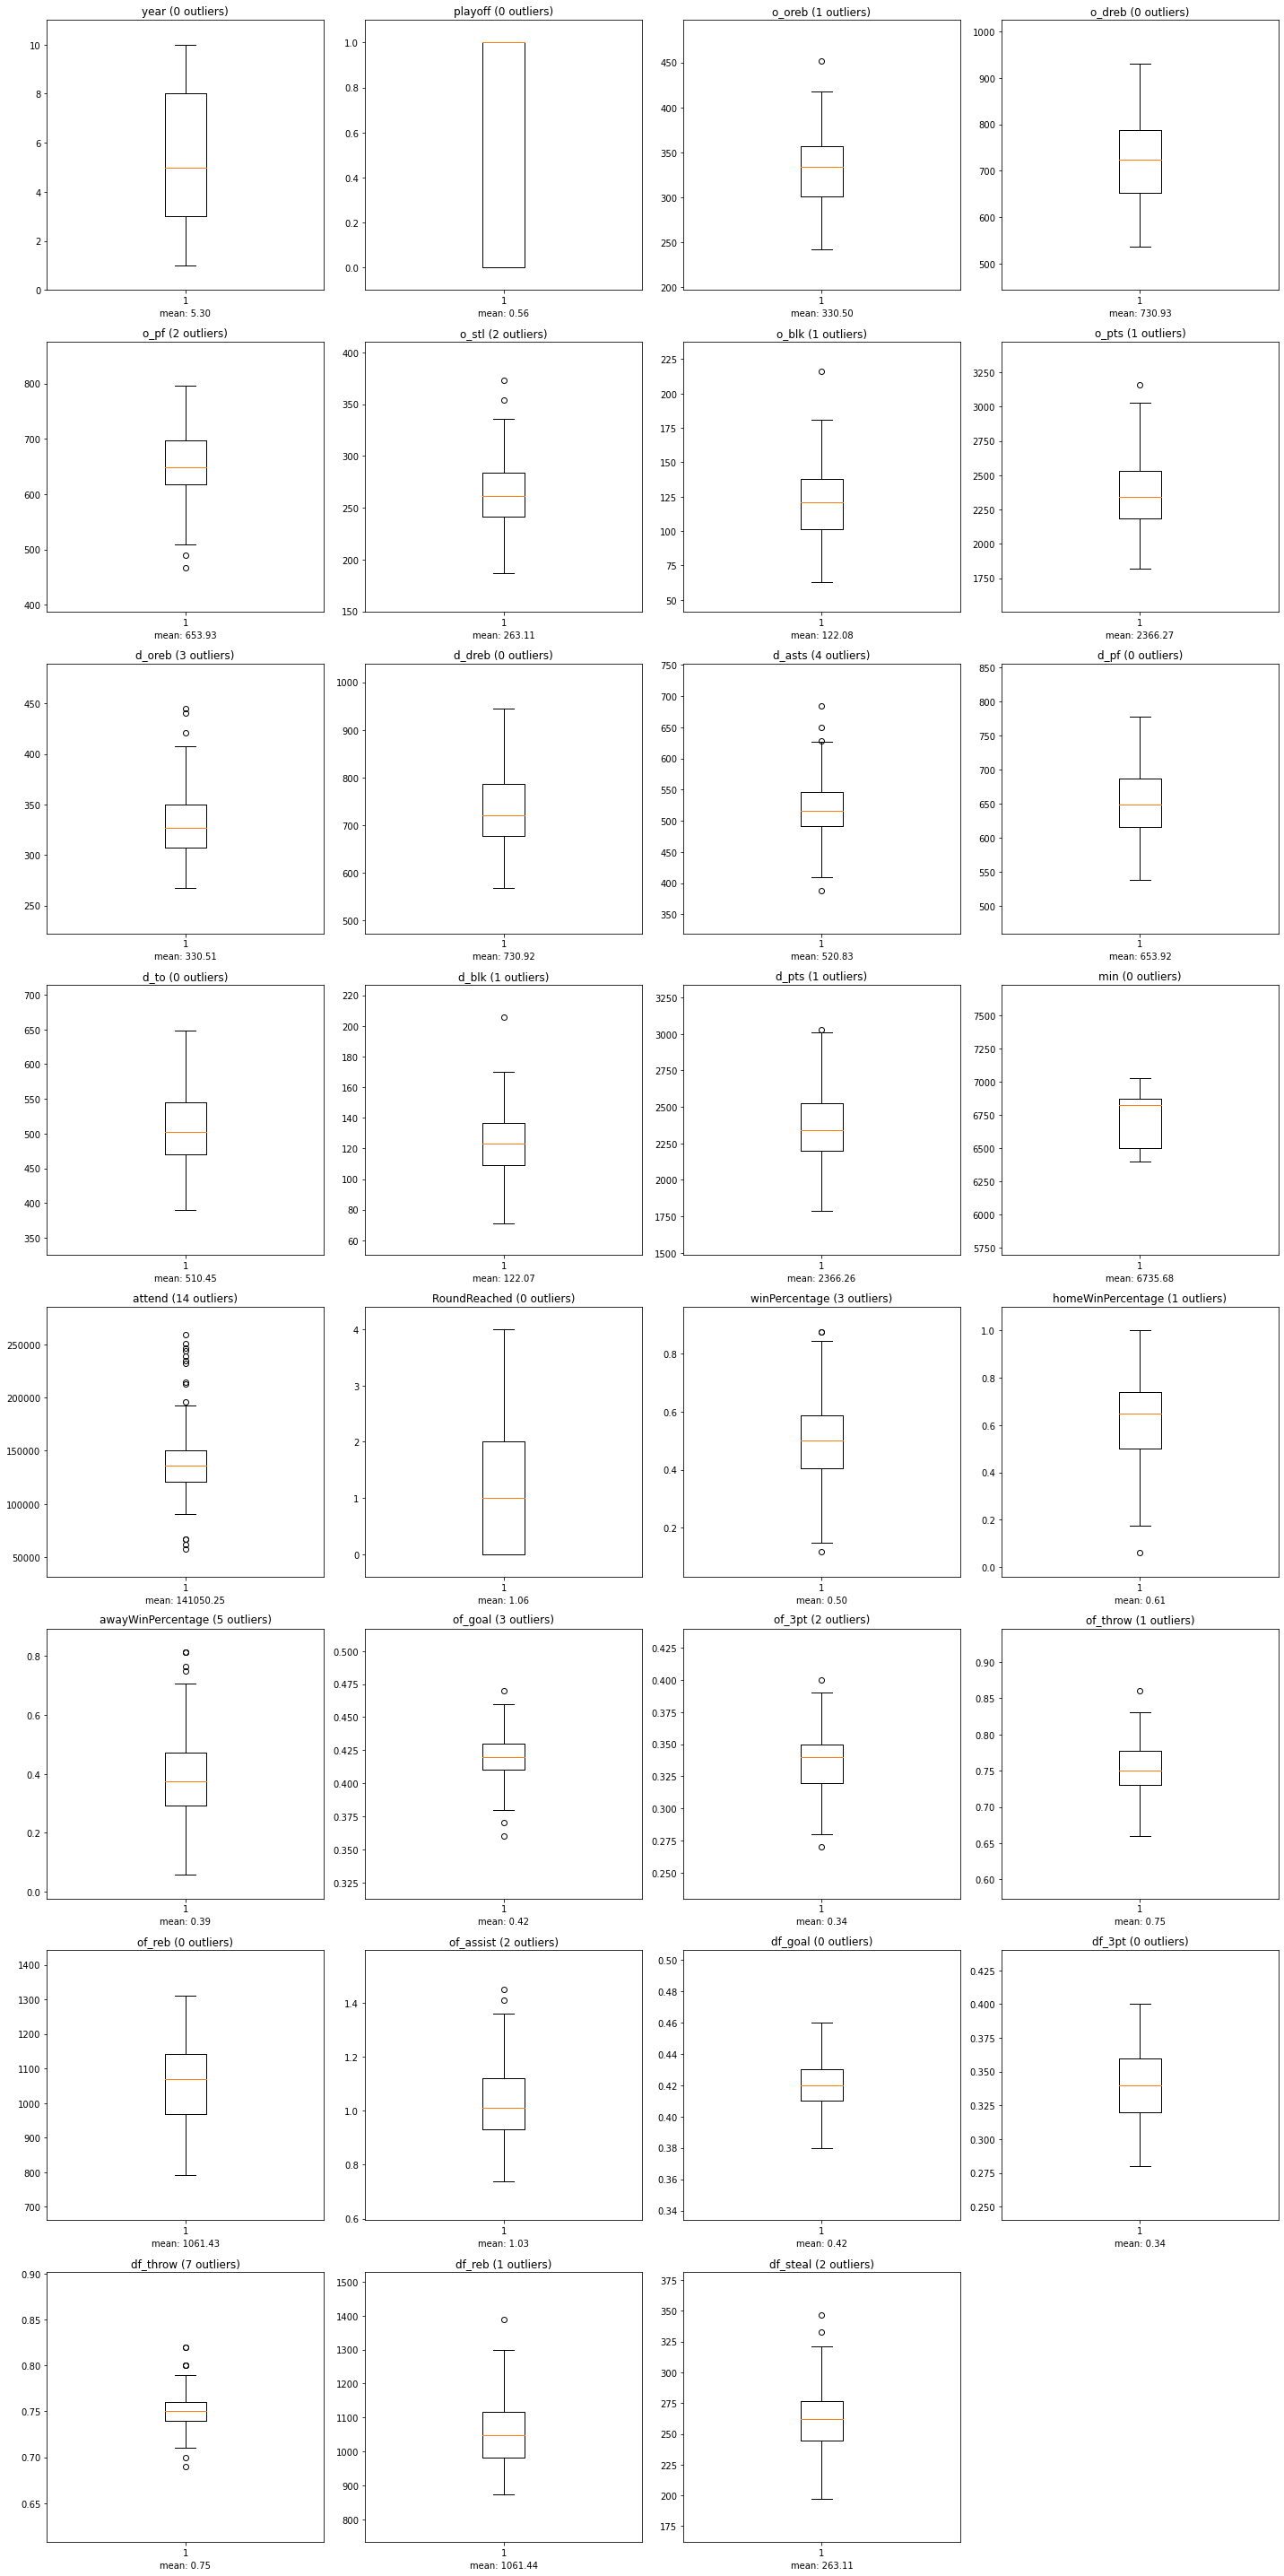


Box plots for Teams Post


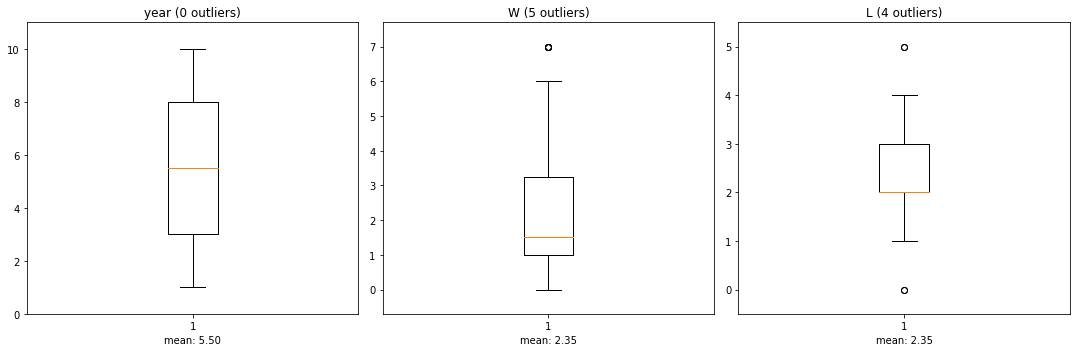


Box plots for Series Post


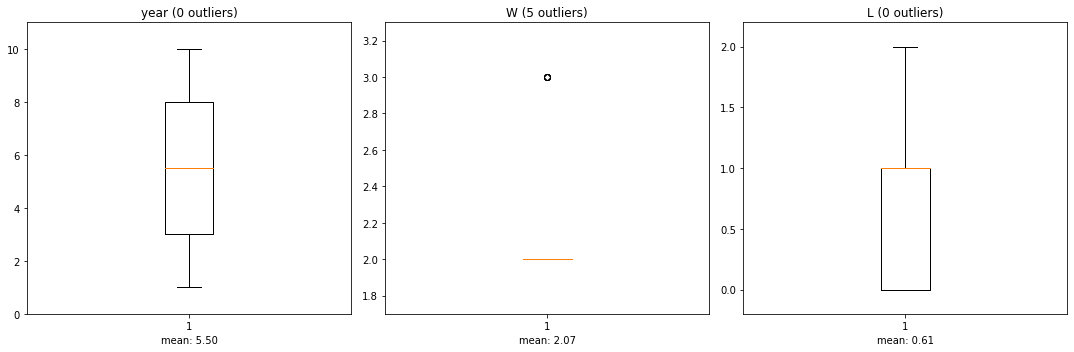


Box plots for Coaches


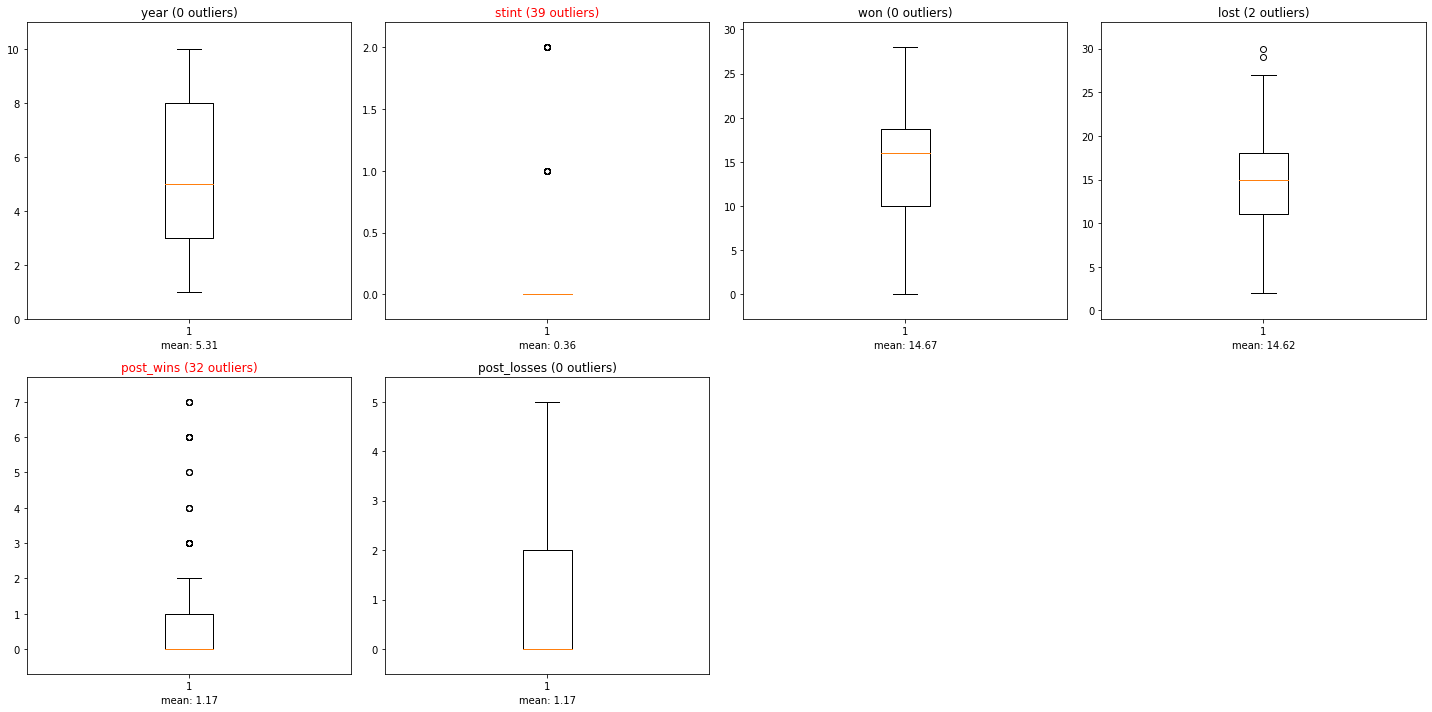


Box plots for Players


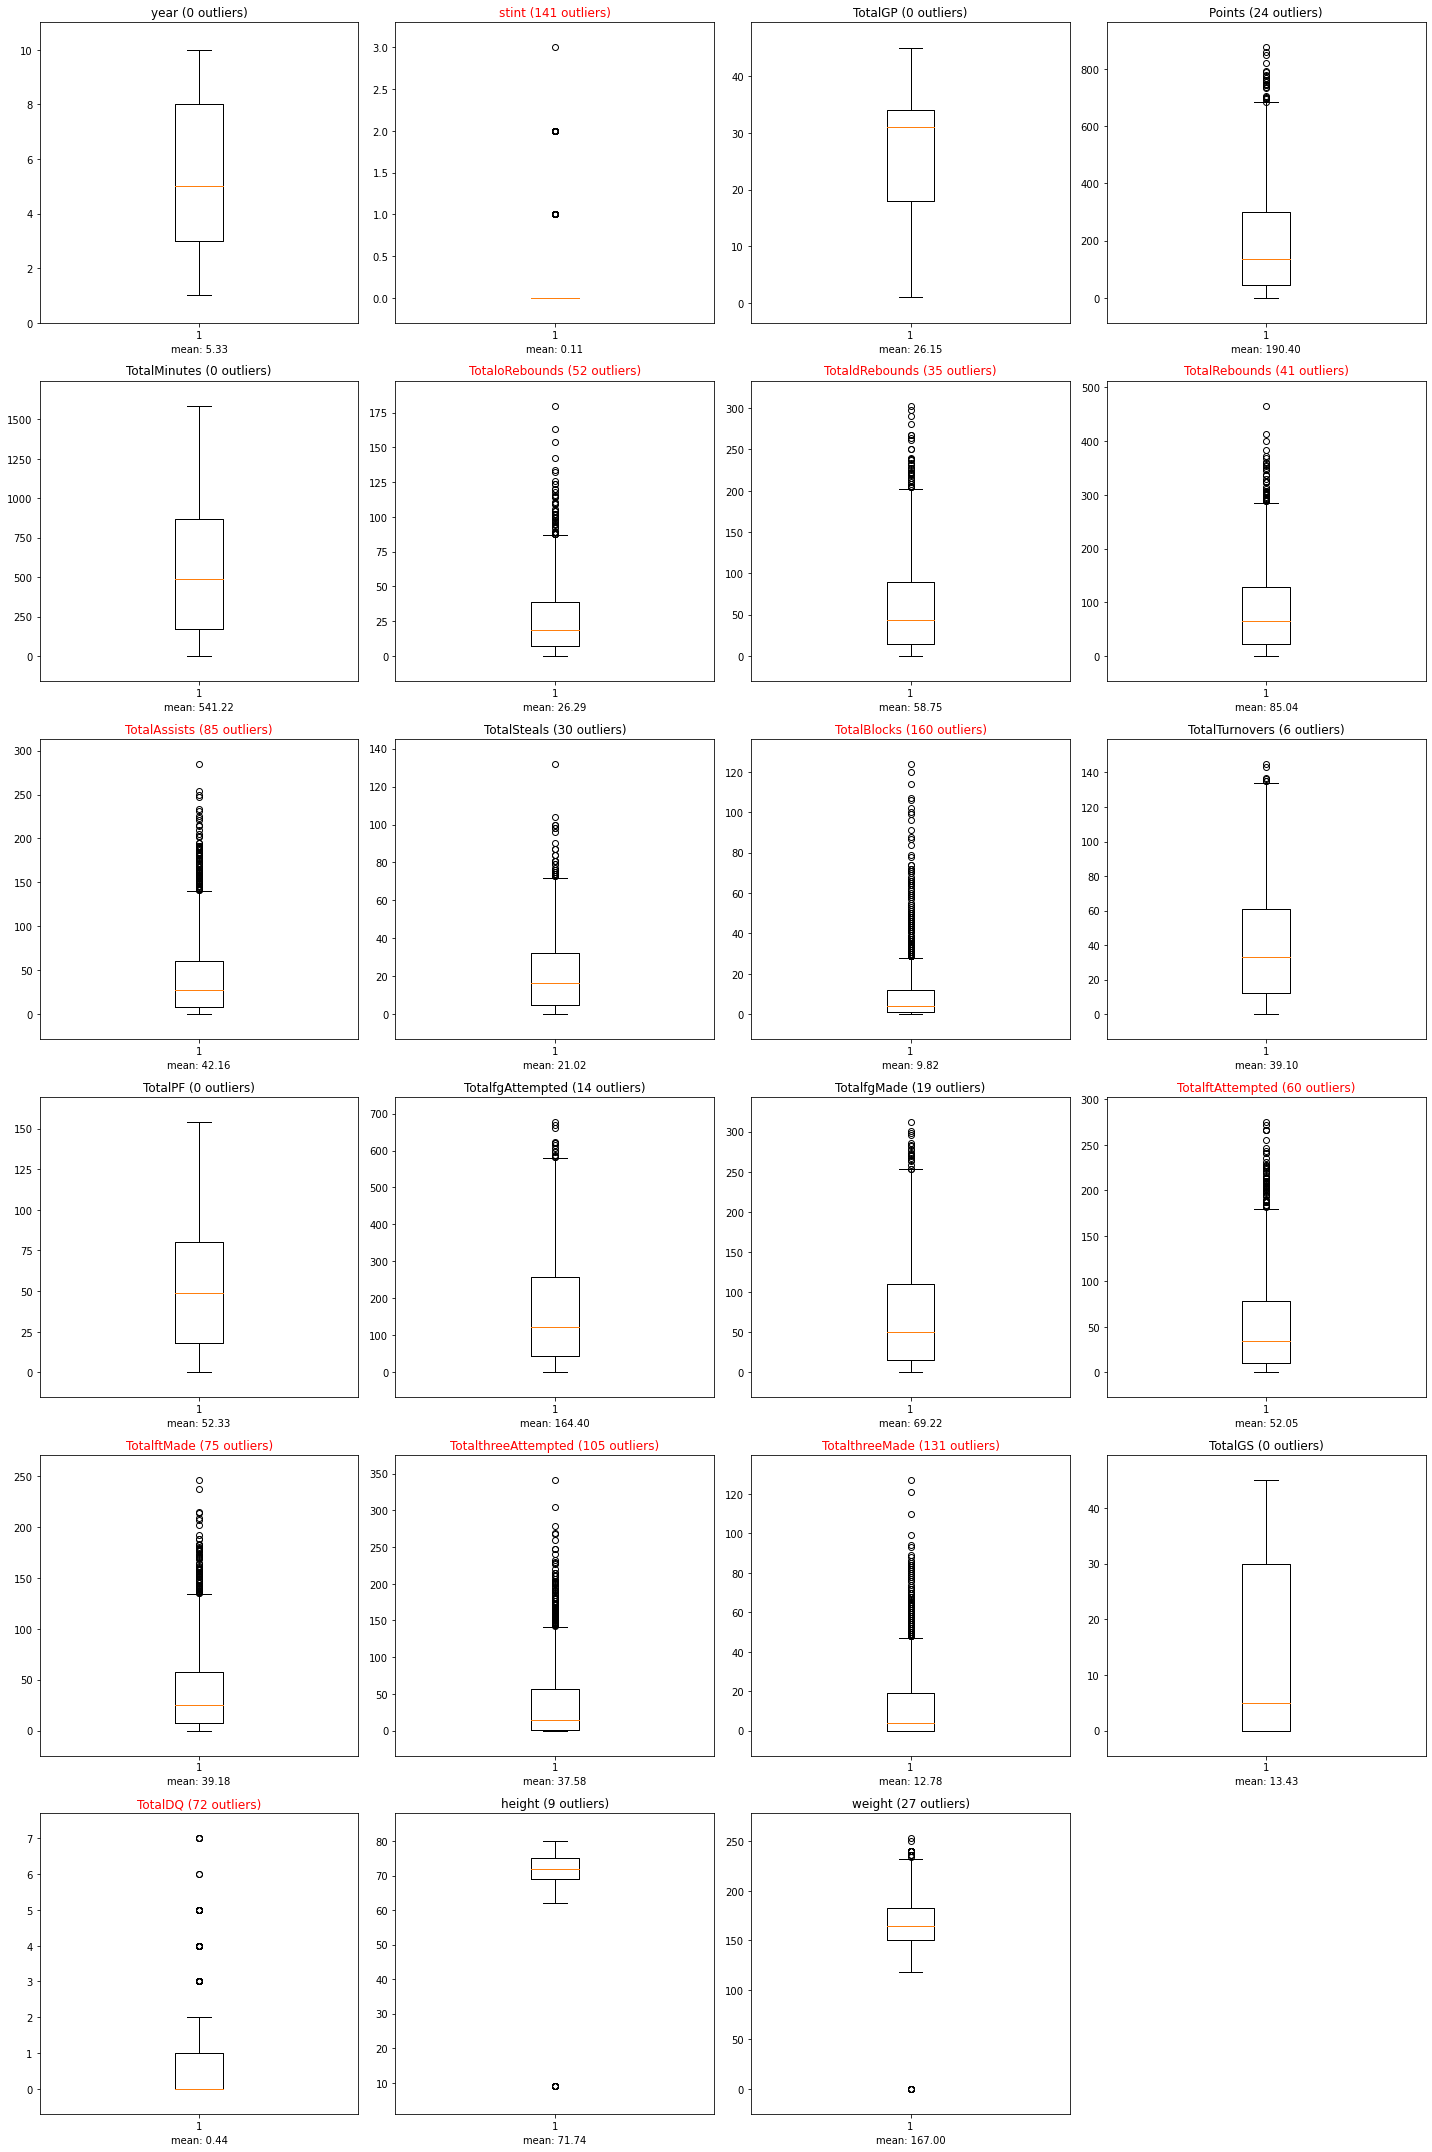

In [ ]:
# Looking for outliers in each df

for i, df in enumerate(df_list_cleaned):
    num = df.select_dtypes(include=['number'])
    if len(num.columns) > 1:
        print(f"\nBox plots for {df_names[i]}")
        show_box_plots(df)


As we can see, the data is free of outliers apart excluding some specific attributes, where there are lots of outliers. Normally, this would be a problem that we would need to address, but taking a look at the data, we can see that the outliers are not errors, but rather breaking of the norm. For example, winning players and teams are naturaly going to have more goals, assists, etc. than losing players and teams, and thus be outside of the median values. The same happens for instance for number of blocks or points made, as there are players that are more defensive and others that are more offensive.

/home/m/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


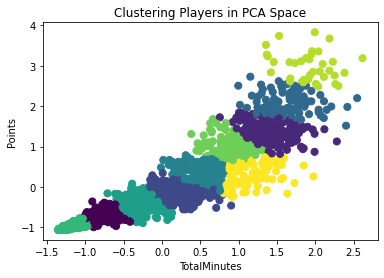

In [ ]:
show_clustering(df_players, 'TotalMinutes', 'Points')

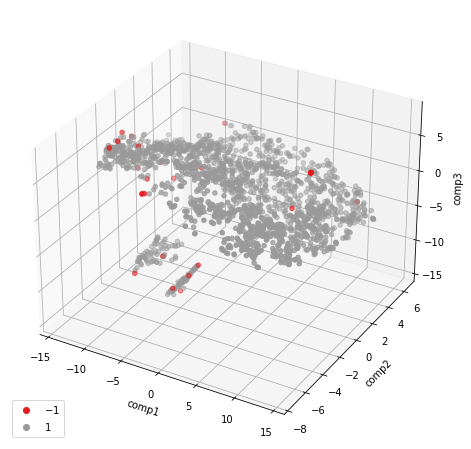

['atkinla01w' 'augusse01w' 'berezva01w' 'byearla01w' 'chriska01w'
 'clinest01w' 'coopecy01w' 'crockwi01w' 'davista02w' 'dydekma01w'
 'francde01w' 'givench01w' 'hornbal01w' 'johnste01w' 'millebr01w'
 'sanniol01w' 'scottol01w' 'smithty01w' 'terryka01w' 'walkeay01w'
 'walkema01w' 'wiggica01w']


In [ ]:


def outliers_pipeline(X_):

    steps = [('scale', StandardScaler()),
             ('LOF', LocalOutlierFactor())
             ]
    outliers = Pipeline(steps).fit_predict(X_)

    return outliers


def print_outliers_plot(X_scaled, outliers, perp=50):

    # we need a good perplexity value to separate the groups
    tsne = TSNE(perplexity=perp, n_components=3).fit_transform(X_scaled)
    tsne = pandas.DataFrame(tsne, columns=['comp1', 'comp2', 'comp3'])
    tsne['outliers'] = outliers

    fig = plt.figure(figsize=(8, 8))  # create a new figure
    ax = fig.add_subplot(111, projection='3d')  # create a 3D subplot
    scatter = ax.scatter(tsne['comp1'], tsne['comp2'], tsne['comp3'],
                         c=tsne['outliers'], cmap='Set1')  # create 3D scatter plot
    #
    # add labels and legend
    ax.set_xlabel('comp1')
    ax.set_ylabel('comp2')
    ax.set_zlabel('comp3')
    plt.legend(*scatter.legend_elements(), loc='lower left')

    plt.show()  # display the plot

    return


players = df_players.select_dtypes(include=['number'])

X = players.iloc[:, 1:].values

outliers = outliers_pipeline(X)

players['outliers'] = outliers
players['playerID'] = df_players['playerID']


# Get the attribute names before scaling
attribute_names = players.columns[1:]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print_outliers_plot(X_scaled, outliers)

df_best_and_worst = players[players['outliers'] == -1]
df_best_and_worst = df_best_and_worst.drop(['outliers'], axis=1)

# drop where stint != 0 ... as it skews the data
df_best_and_worst = df_best_and_worst[df_best_and_worst['stint'] == 0]

# show all uniques names
b_w_players = df_best_and_worst['playerID'].unique()

print(b_w_players)


0        F
8        C
9        G
14     F-G
46     G-F
98     F-C
455    C-F
Name: pos, dtype: object
position: F


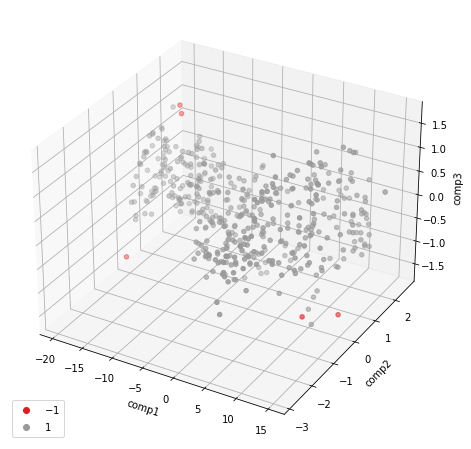

['crockwi01w' 'fordch01w' 'owenhe01w' 'smithty01w']
position: C


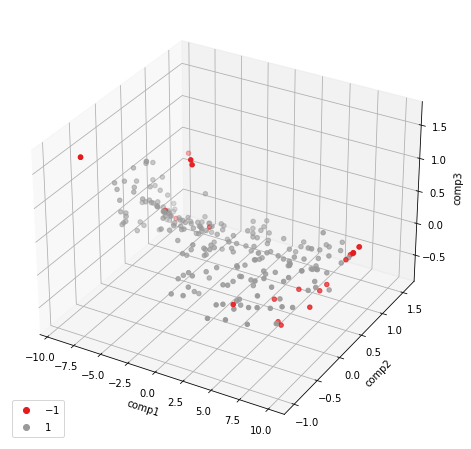

['adamsjo01w' 'batkosu01w' 'berezva01w' 'dydekma01w' 'leslili01w'
 'millebr01w' 'rileyru01w' 'sanniol01w' 'walkema01w' 'wautean01w']
position: G


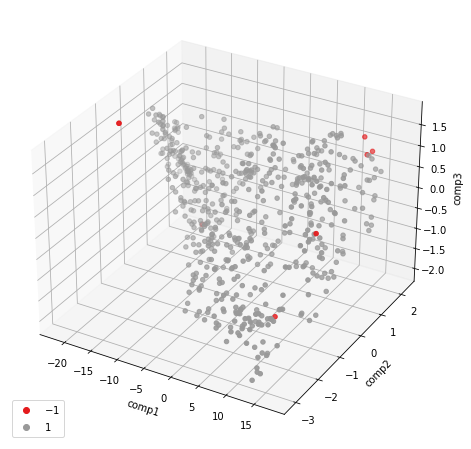

['bonnede01w' 'davista02w' 'givench01w' 'hornbal01w' 'wiggica01w'
 'wrighta01w' 'yamasli01w' 'zellosh01w']
position: F-G


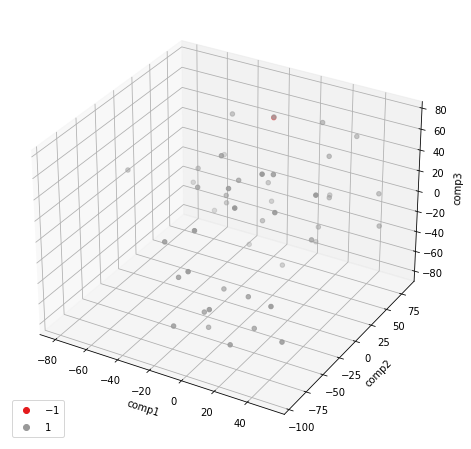

['tauradi01w']
position: G-F


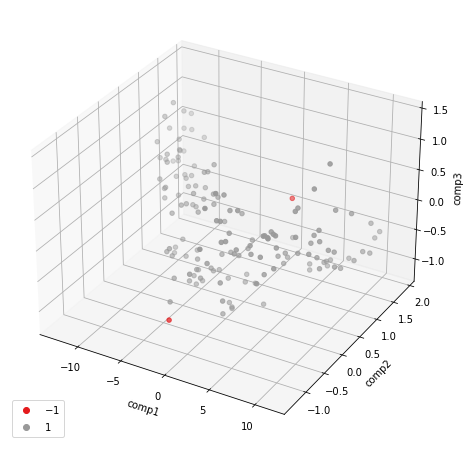

['byearla01w']
position: F-C


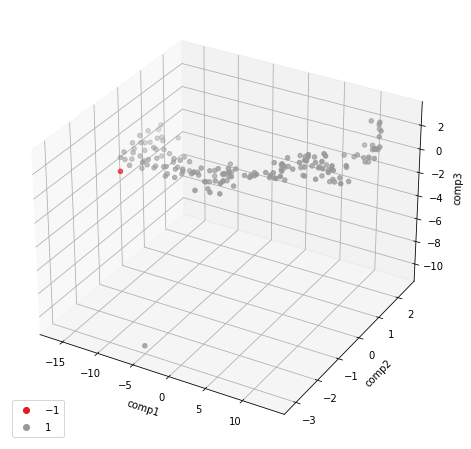

['lazicka01w']
position: C-F


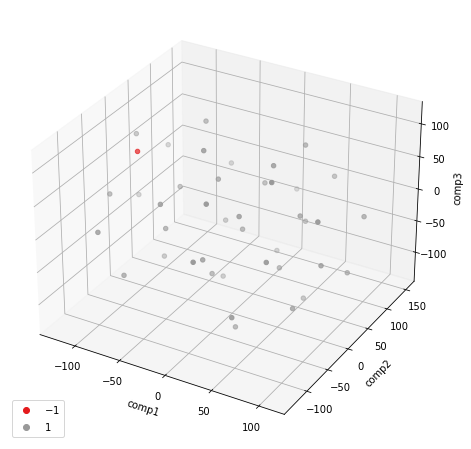

['tilliic01w']


,playerID,year,stint,tmID,TotalGP,Points,TotalMinutes,TotaloRebounds,TotaldRebounds,TotalRebounds,...,TotalfgMade,TotalftAttempted,TotalftMade,TotalthreeAttempted,TotalthreeMade,TotalGS,TotalDQ,pos,height,weight
0,abrossv01w,2,0,MIN,26,343,846,43,131,174,...,114,132,96,76,19,23,2,F,74.0,169
1,abrossv01w,3,0,MIN,27,314,805,45,101,146,...,119,116,56,60,20,27,0,F,74.0,169
2,abrossv01w,4,0,MIN,33,341,861,45,101,146,...,118,106,77,89,28,28,0,F,74.0,169
3,abrossv01w,5,0,MIN,24,166,529,20,63,83,...,57,50,30,61,22,13,0,F,74.0,169
4,abrossv01w,6,0,MIN,31,304,777,29,78,107,...,109,73,53,82,33,31,0,F,74.0,169
5,abrossv01w,7,0,MIN,34,263,724,44,62,106,...,99,62,41,65,24,2,0,F,74.0,169
6,abrossv01w,8,0,MIN,34,345,843,53,97,150,...,132,43,36,101,45,29,0,F,74.0,169
7,abrossv01w,9,0,CON,9,58,170,6,25,31,...,22,16,12,17,2,2,0,F,74.0,169
8,adamsjo01w,4,0,MIN,10,33,96,10,13,23,...,13,2,2,12,5,0,0,C,75.0,180
9,aguilel01w,3,0,UTA,30,43,145,0,11,11,...,14,7,4,21,11,0,0,G,67.0,165


In [ ]:
unique_position = df_players['pos']
unique_position = unique_position.drop_duplicates()
# # TODO ... make this for every type of position / taking in case the defensive and ofensive statistics


print(unique_position)

perp = [50, 50, 50, 10, 25, 25, 25]

perp_index = 0
for i in unique_position:
    df_i = df_players[df_players['pos'] == i]

    df_i = df_i.drop(['tmID', 'pos'], axis=1)

    df_i = df_i[df_i['stint'] == 0]

    x = df_i.iloc[:, 1:].values

    print(f"position: {i}")
    outliers = outliers_pipeline(x)
    df_i['outliers'] = outliers

    print_outliers_plot(x, outliers, perp=perp[perp_index])

    # print the outliers
    df_i = df_i[df_i['outliers'] == -1]
    df_i = df_i.drop(['outliers'], axis=1)
    print(df_i['playerID'].unique())

    perp_index += 1


df_players.head(20)


### Attribute Distributions


Histograms for Teams


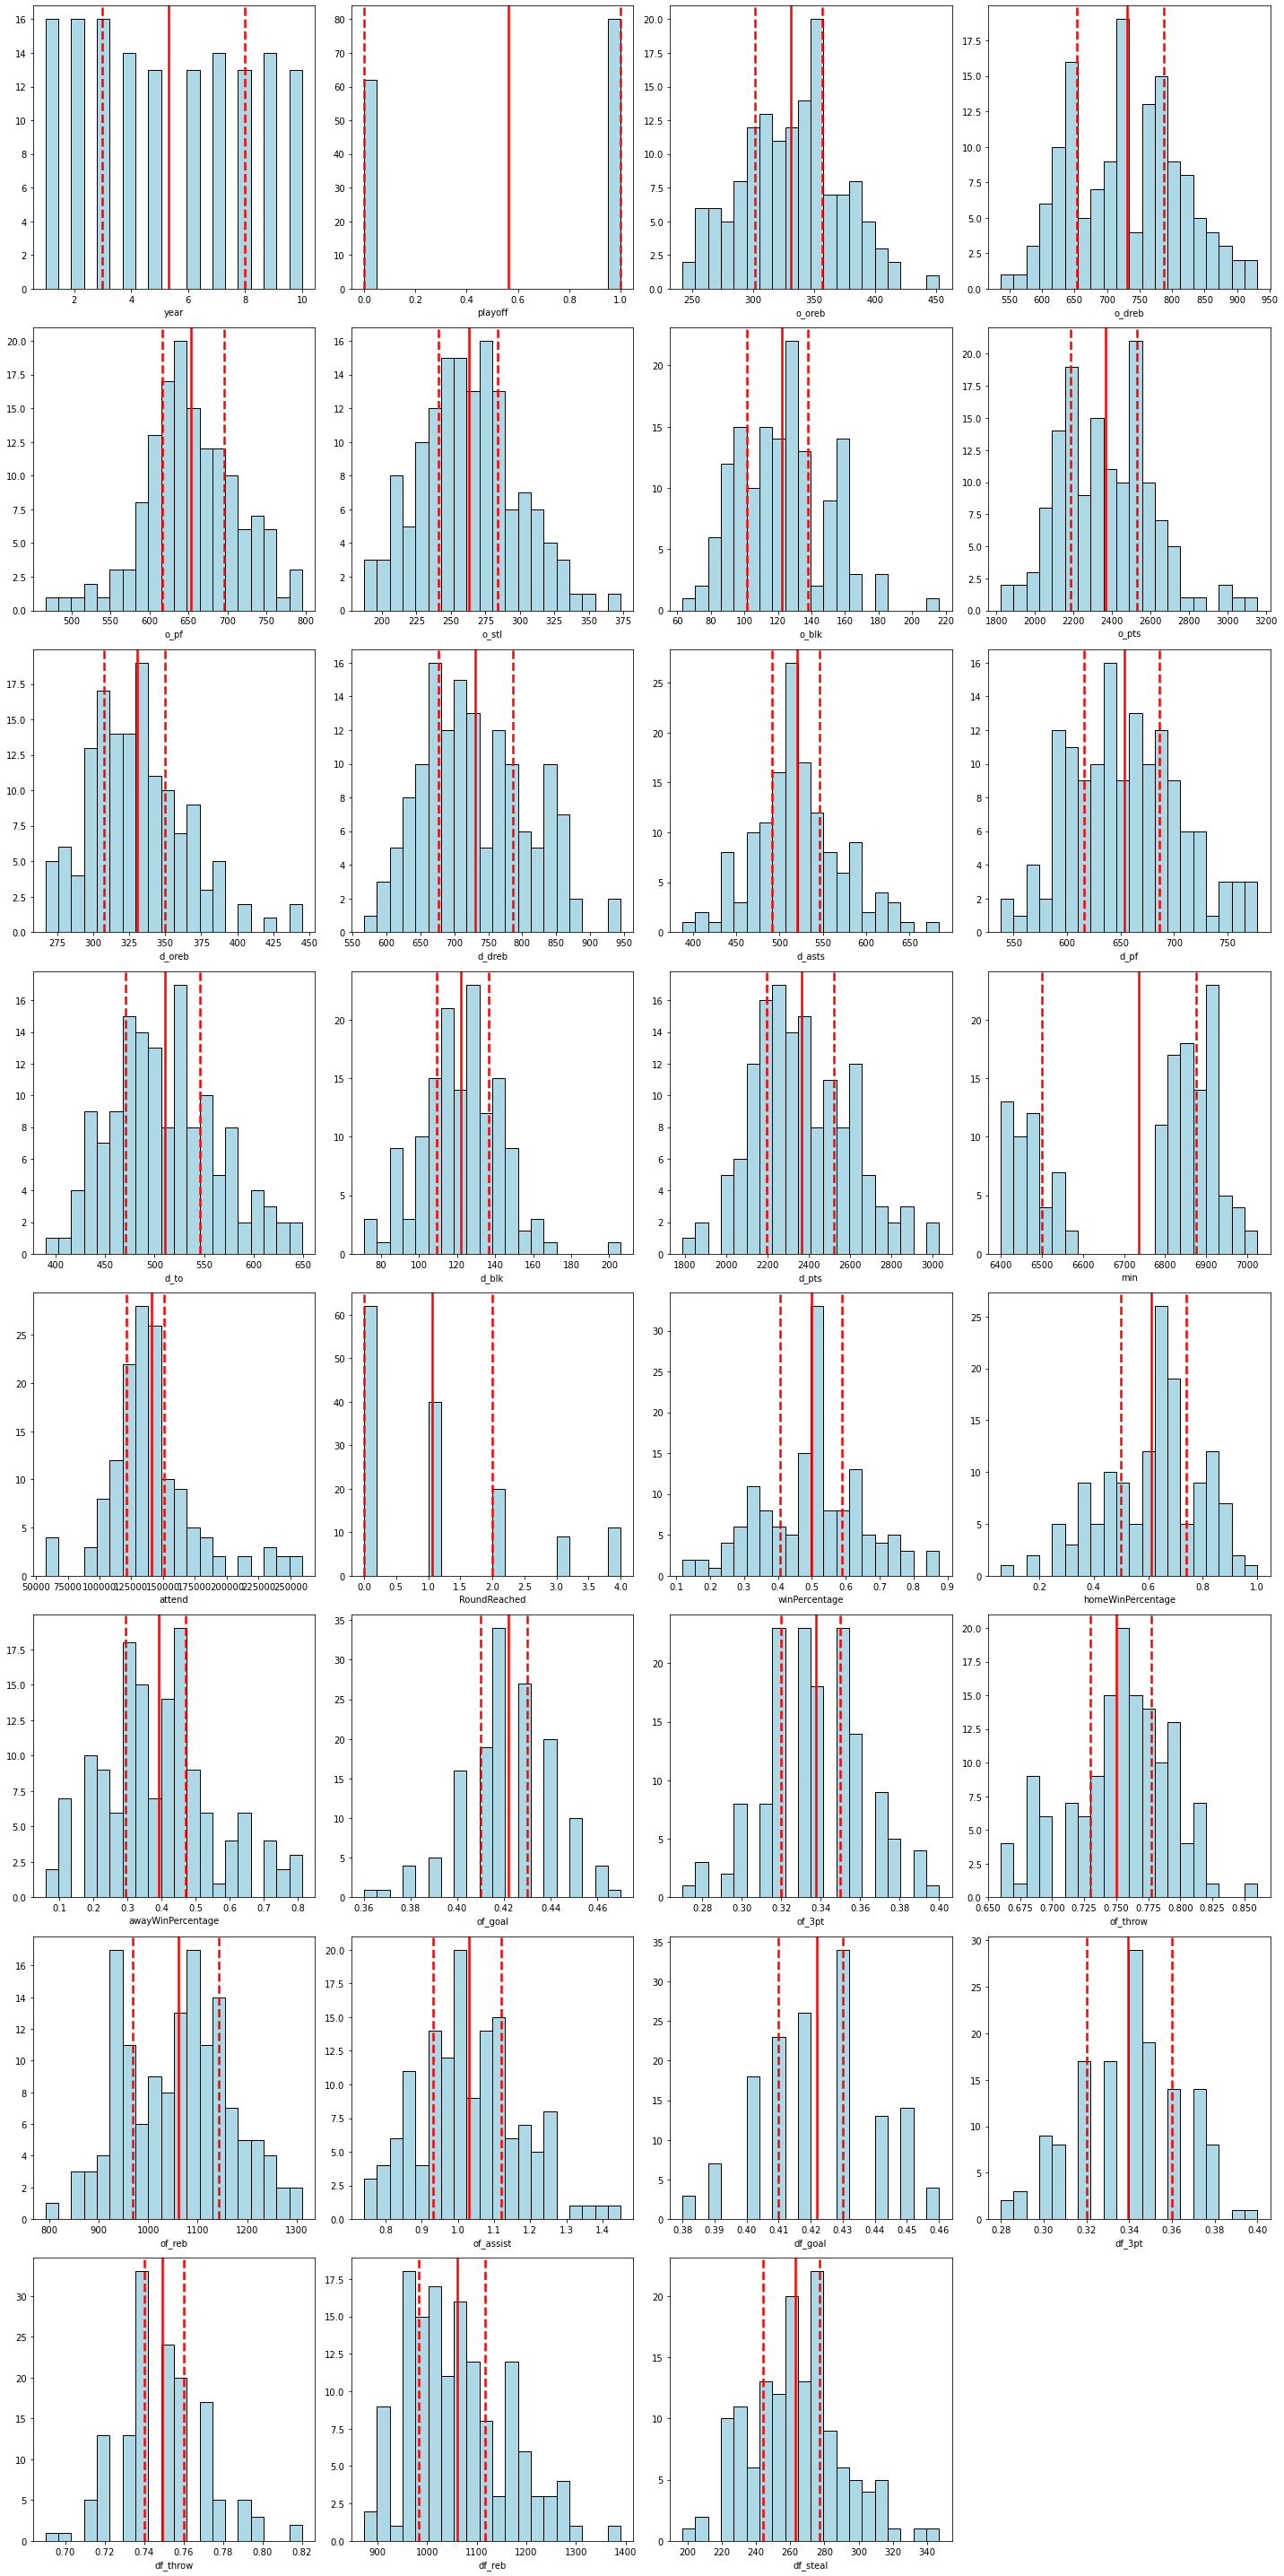


Histograms for Teams Post


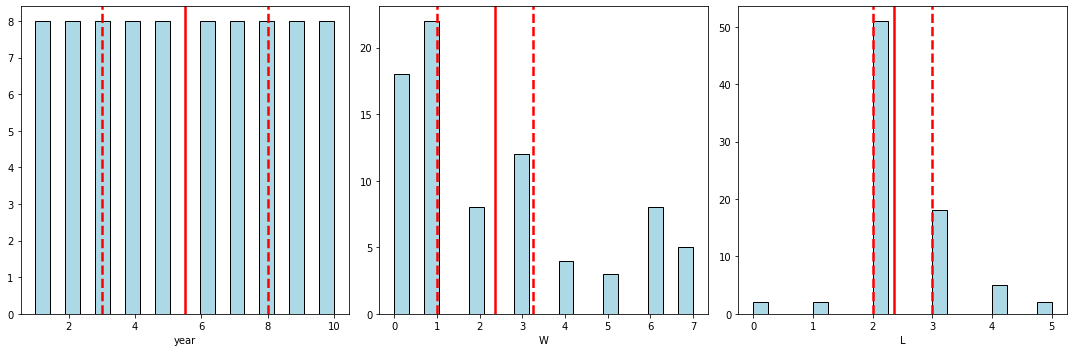


Histograms for Series Post


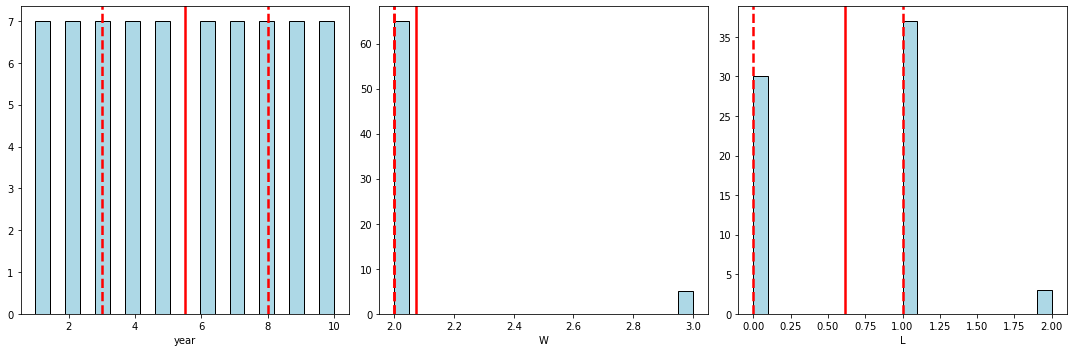


Histograms for Coaches


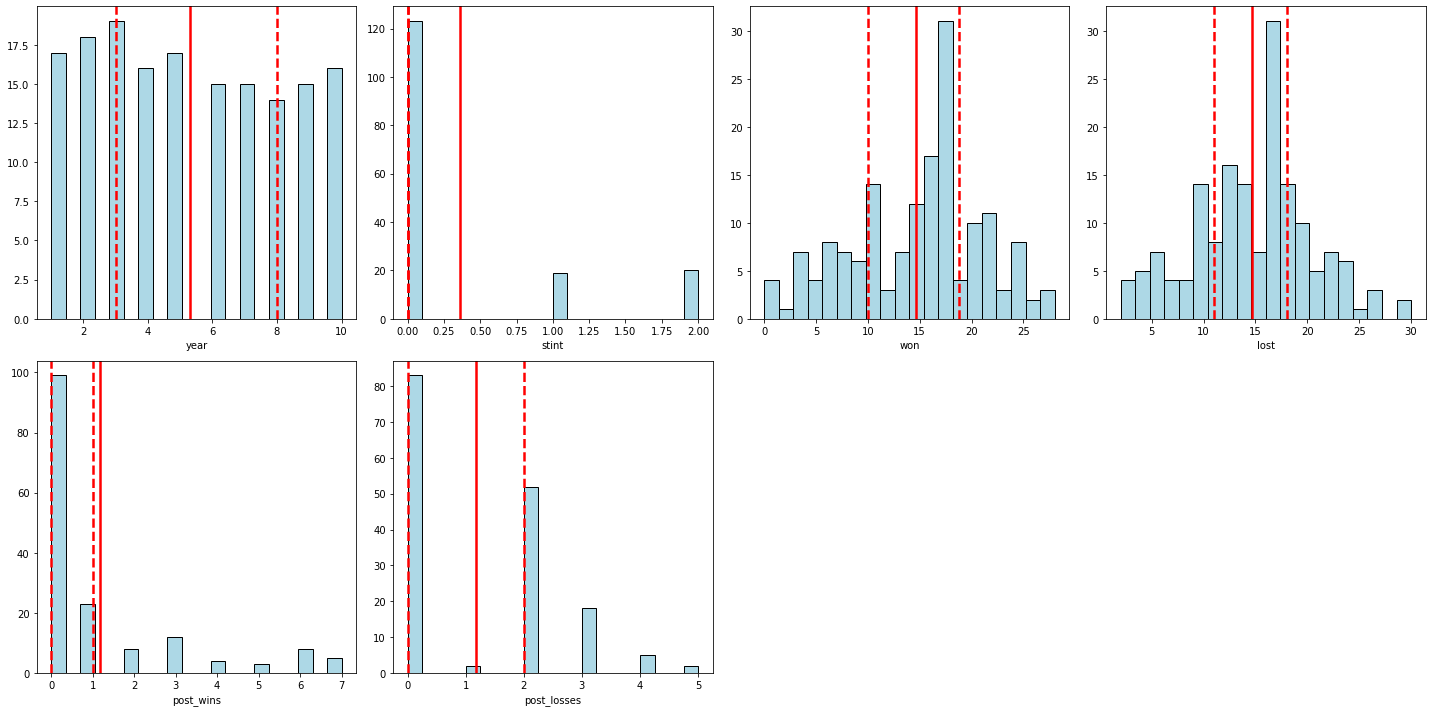


Histograms for Players


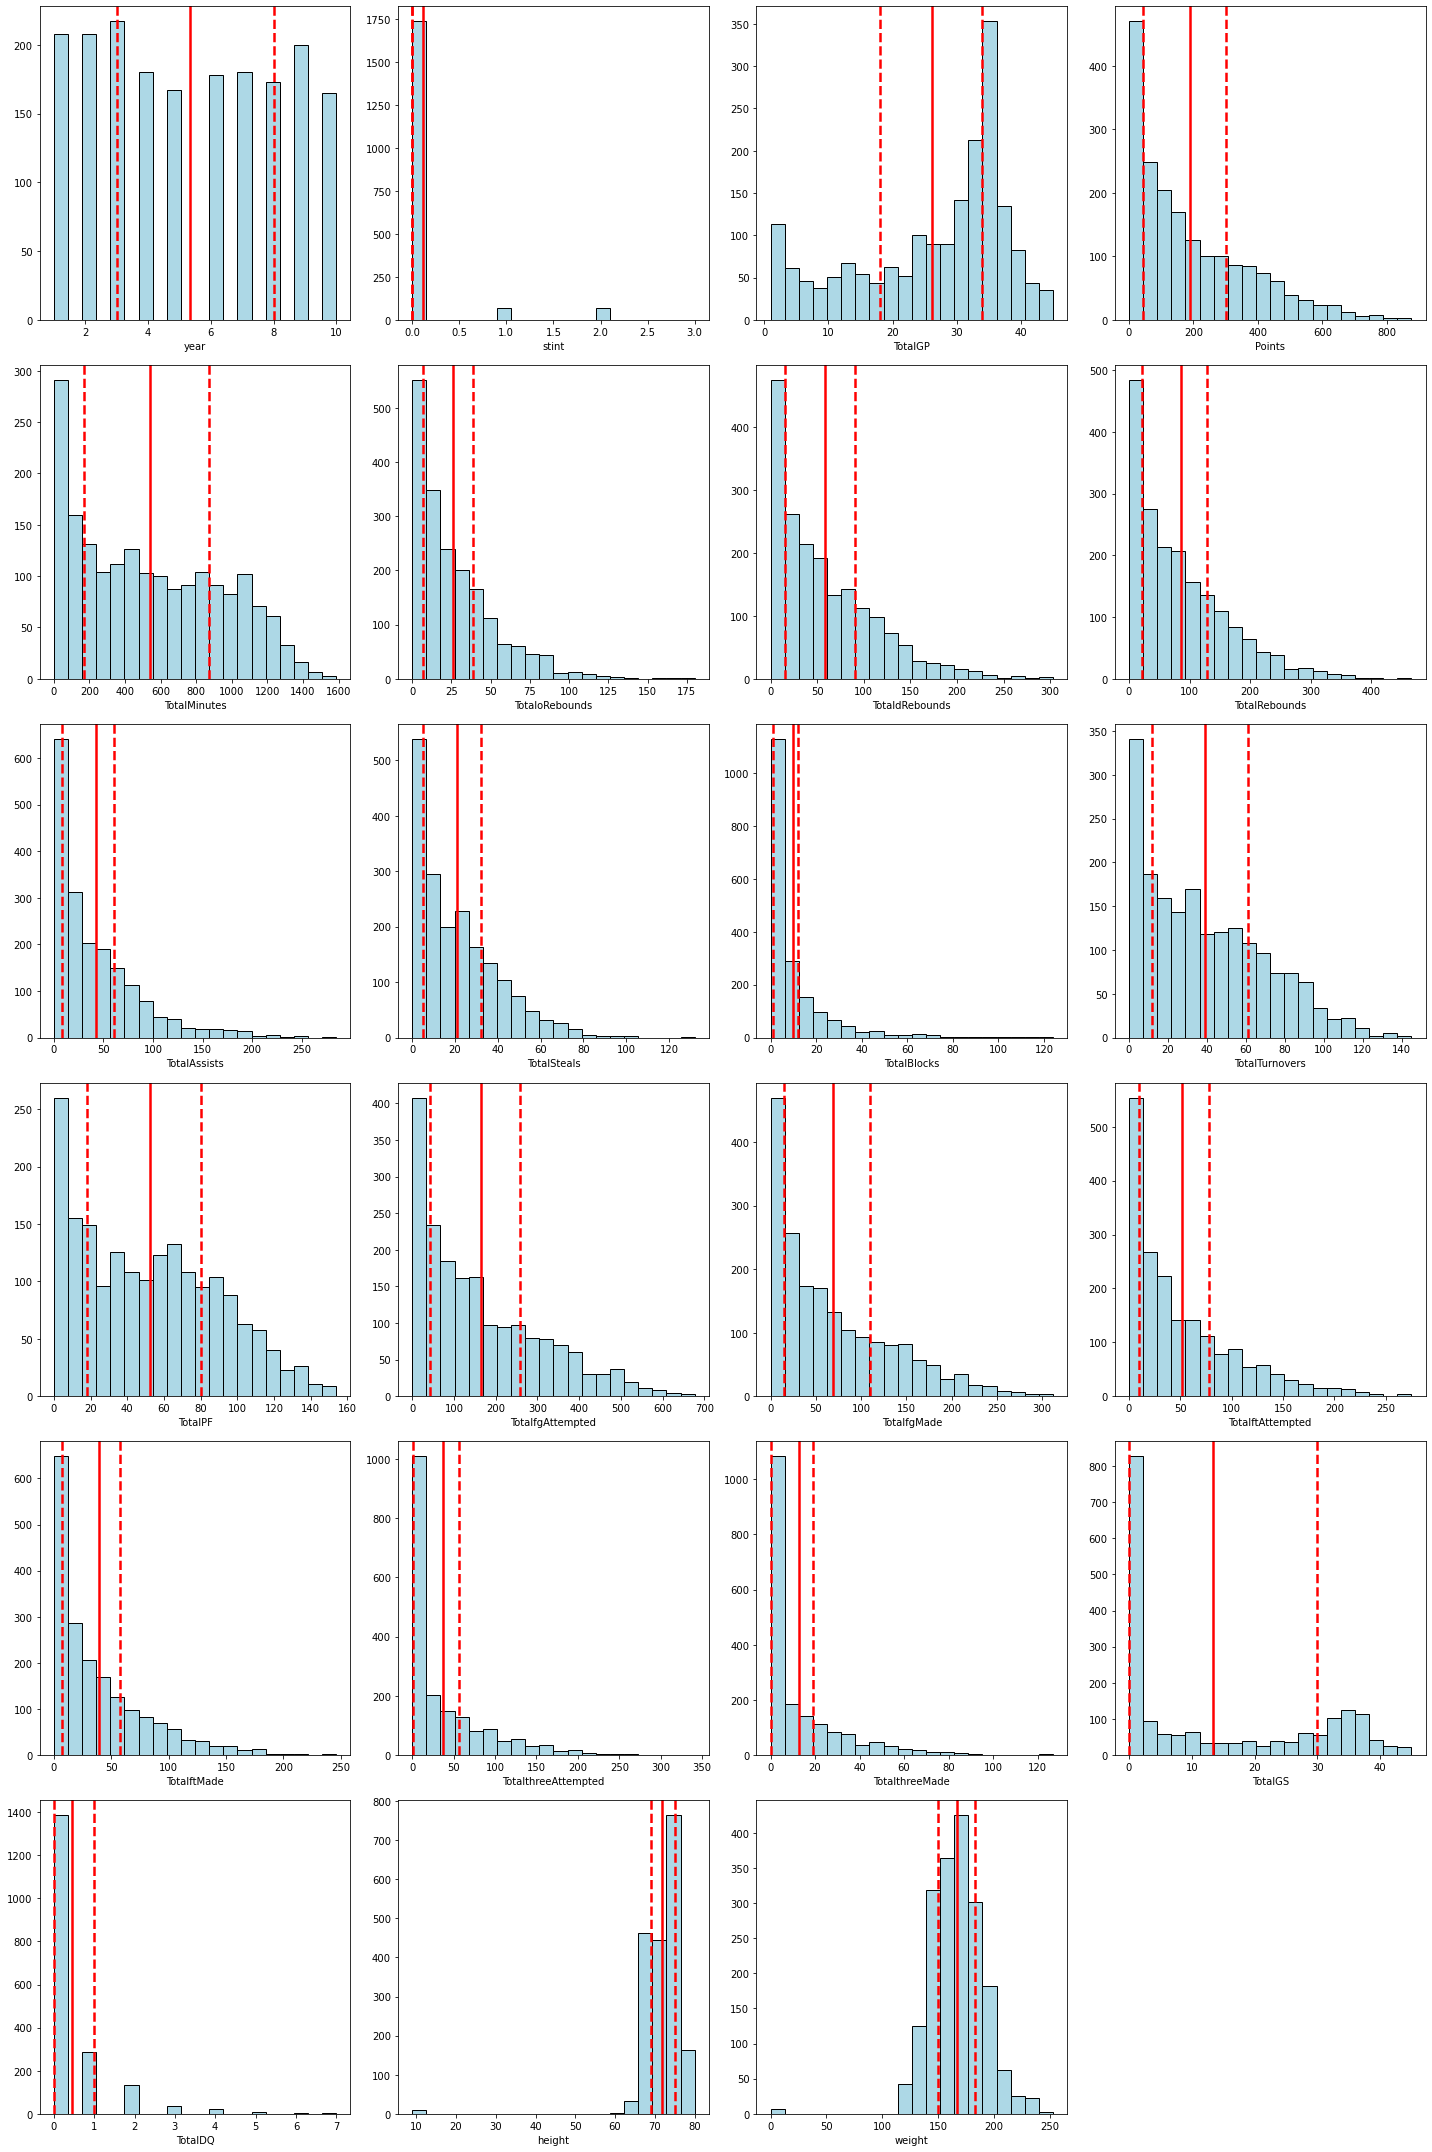

In [ ]:
for i, df in enumerate(df_list_cleaned):
    num = df.select_dtypes(include=['number'])
    if len(num.columns) > 1:
        print(f"\nHistograms for {df_names[i]}")
        show_hist_plots(df)


### PCA (Principal Component Analysis)

We are doing a Standard (Decrement) PCA, which is the most common one, to reduce the number of attributes to a more manageable number while avoiding losing attribute combinations that might be important.

In [ ]:
def perform_pca(df, threshold=0.95):
    df = df.select_dtypes(include=['number'])

    pca = PCA()
    pca.fit(df)

    explained_variance_ratio = pca.explained_variance_ratio_

    # Find the most important attributes based on the threshold
    cumulative_variance_ratio = explained_variance_ratio.cumsum()
    important_attributes = list(
        df.columns[cumulative_variance_ratio >= threshold])

    return important_attributes


def get_useless_attributes(df, important_attributes):
    useless_attributes = list(set(df.columns) - set(important_attributes))
    return useless_attributes


In [ ]:
for i, df in enumerate(df_list_cleaned):
    print(f"\n============== PCA for {df_names[i]} ==============")
    important_attributes = perform_pca(df)
    useless_attributes = get_useless_attributes(df, important_attributes)
    print(f"Useless attributes: {useless_attributes}")
    aux = f"{len(useless_attributes)} (out of {len(df.columns)})"
    print(f"Nº of useless attrs: {aux}")
    perc = len(useless_attributes)/len(df.columns)*100
    print(f"Percentage of useless attrs: {perc:.2f}%")



============== PCA for Teams ==============
Useless attributes: ['tmID', 'confID']
Nº of useless attrs: 2 (out of 33)
Percentage of useless attrs: 6.06%

============== PCA for Teams Post ==============
Useless attributes: ['tmID', 'year']
Nº of useless attrs: 2 (out of 4)
Percentage of useless attrs: 50.00%

============== PCA for Series Post ==============
Useless attributes: ['tmIDWinner', 'round', 'tmIDLoser', 'series']
Nº of useless attrs: 4 (out of 7)
Percentage of useless attrs: 57.14%

============== PCA for Coaches ==============
Useless attributes: ['stint', 'coachID', 'tmID', 'year']
Nº of useless attrs: 4 (out of 8)
Percentage of useless attrs: 50.00%

============== PCA for Awards Players ==============
Useless attributes: ['award', 'playerID']
Nº of useless attrs: 2 (out of 3)
Percentage of useless attrs: 66.67%

============== PCA for Players ==============
Useless attributes: ['tmID', 'playerID', 'pos', 'year']
Nº of useless attrs: 4 (out of 26)
Percentage of useless a

As we can see, there are components that can be removed in every dataframe. For some, we can remove more than 50% of the components, which is a great reduction. However some are related to ID's, which we will need to keep, and others are related to the year, which we will also need to keep.